# Deploy image as web service on Azure Container Instance¶ 

In [1]:
%matplotlib inline

import requests
from azureml.core import Workspace
from azureml.core.webservice import AciWebservice
from azureml.core.webservice import Webservice
from dotenv import set_key, get_key, find_dotenv
from utilities import load_image_into_numpy_array
from PIL import Image

import sys
import os
import json
import numpy as np
sys.path.append("../models/research/")
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import label_map_util
from matplotlib import pyplot as plt

In [2]:
env_path = find_dotenv(raise_error_if_not_found=True)

In [3]:
ws = Workspace.from_config()
# print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Found the config file in: /datadrive/OutOfStockDemo/.azureml/config.json


In [19]:
aciconfig = AciWebservice.deploy_configuration(cpu_cores=3,
                                location="westus",
                                memory_gb=7,
                                tags={"data": "product",  "method" : "tensorflow"}, 
                                description='Predict out of stock with tensorflow')

In [20]:
image_name =  get_key(env_path, 'image_name')
image = ws.images[image_name]
print(image.name, image.version)

maskrcnnoutofstockimage 1


In [21]:
%%time

aci_service_name = 'maskrcnn-oos-service'
print(aci_service_name)
aci_service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                           image = image,
                                           name = aci_service_name,
                                           workspace = ws)
aci_service.wait_for_deployment(True)
print(aci_service.state)

maskrcnn-oos-service
Creating service
Running.
FailedACI service creation operation finished, operation "Failed"
Service creation polling reached terminal state, current service state: Transitioning
{
  "code": "ServiceUnavailable",
  "statusCode": 409,
  "message": "ACI Service request failed. Reason: The requested resource is not available in the location 'westus' at this moment. Please retry with a different resource request or in another location. Resource requested: '4' CPU '7.5' GB memory 'Linux' OS."
}
Transitioning
CPU times: user 93.4 ms, sys: 5.32 ms, total: 98.7 ms
Wall time: 7.28 s


# Test Webservice

In [6]:
img_data = open('/datadrive/KrogerDemo/annotated/runeightft3/1555539843.1911.jpg', "rb")
%time r = requests.post(aci_service.scoring_uri, files={'image': img_data})

CPU times: user 2.08 ms, sys: 2.3 ms, total: 4.38 ms
Wall time: 9.02 s


In [7]:
print(r)
r.json()

<Response [200]>


'{"num_detections": 17, "detection_boxes": [[0.3454636335372925, 0.30646976828575134, 0.5321506857872009, 0.40197625756263733], [0.3285095989704132, 0.6001223921775818, 0.5263990163803101, 0.6833875775337219], [0.848839282989502, 0.5878943204879761, 0.920777440071106, 0.6470942497253418], [0.7298493385314941, 0.7013081312179565, 0.8170970678329468, 0.7401634454727173], [0.7288271188735962, 0.5116227269172668, 0.8164384365081787, 0.5646620392799377], [0.5676727294921875, 0.6720635890960693, 0.697401762008667, 0.7273334264755249], [0.18834678828716278, 0.2714961767196655, 0.28960058093070984, 0.3860042691230774], [0.849273681640625, 0.40368613600730896, 0.9261741638183594, 0.4390243589878082], [0.16463544964790344, 0.5101472735404968, 0.26596564054489136, 0.6212332844734192], [0.5631101131439209, 0.4124484360218048, 0.6956672668457031, 0.4507392346858978], [0.5589526891708374, 0.5611917972564697, 0.6912441253662109, 0.6107845306396484], [0.7310645580291748, 0.31891918182373047, 0.8190897

In [8]:
PATH_TO_LABELS = 'stockout_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

IMAGE_SIZE = (24, 18)

In [11]:
img = Image.open(img_data)
image_np = load_image_into_numpy_array(img)
output_dict = json.loads(r.json())

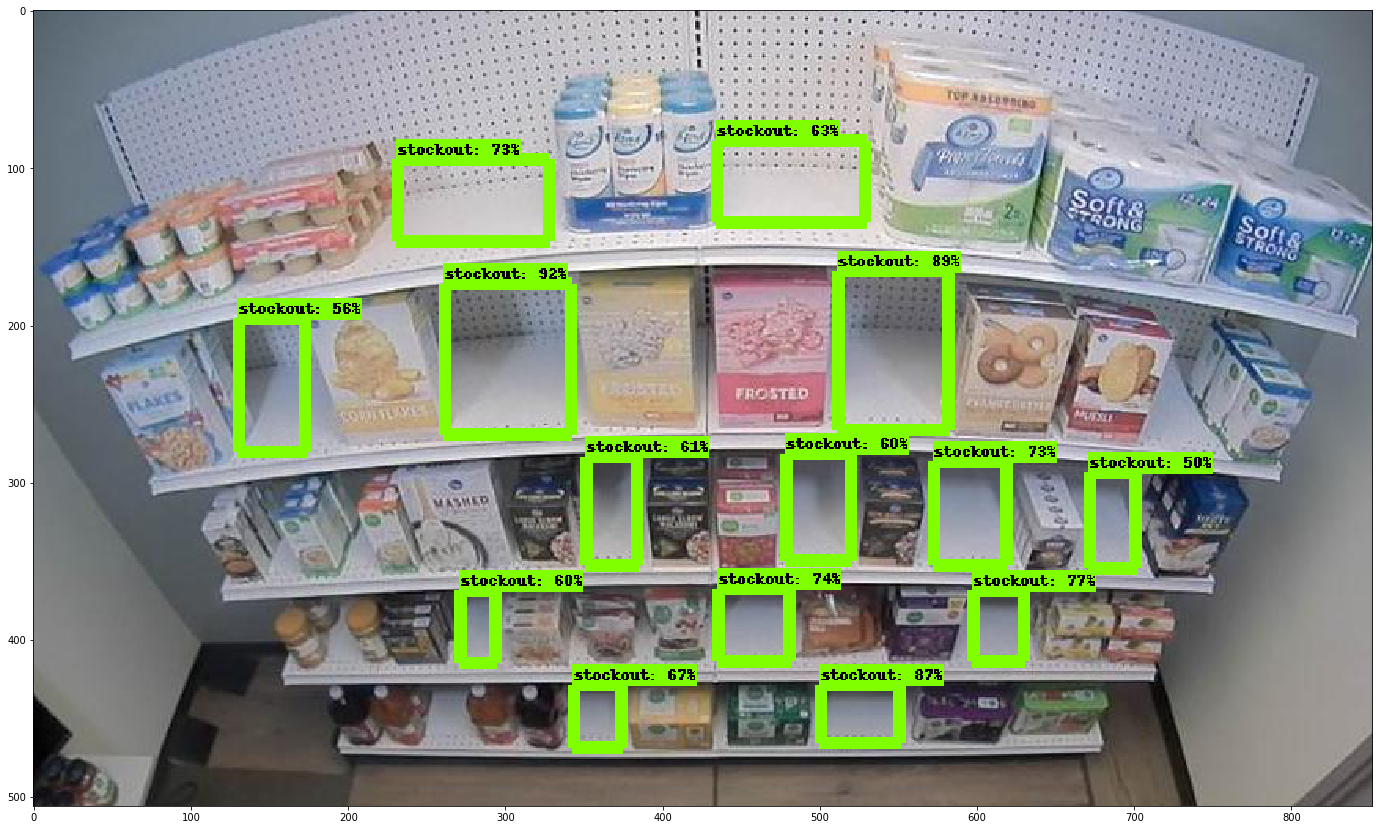

In [12]:
vis_util.visualize_boxes_and_labels_on_image_array(
  image_np,
  np.array(output_dict['detection_boxes']),
  np.array(output_dict['detection_classes']),
  np.array(output_dict['detection_scores']),
  category_index,
  instance_masks=output_dict.get('detection_masks'),
  use_normalized_coordinates=True,
  line_thickness=8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)

# Cleanup

In [7]:
aci_service = Webservice(ws, name=aci_service_name )

In [2]:
aci_service.delete()